In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.optimize import curve_fit


from altaipony.fakeflares import flare_model

In [2]:
# GET THE IMAGE DATA -----------------------------------------------------------
file = "20240325102059"
IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/hip67522_CHEOPS-products-{file}_im.fits'
hdulist = fits.open(IMG)
print(f"Imagette file found for {file}:\n {IMG}\n")


# get the image data
image_data = hdulist[1].data

t, f, ferr, roll = image_data["BJD_TIME"], image_data["FLUX"], image_data["FLUXERR"], image_data["ROLL"]

# make sure the data is in fact 10s cadence
assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

# big endian to little endian
t = t.byteswap().newbyteorder()
f = f.byteswap().newbyteorder()
ferr = ferr.byteswap().newbyteorder()
roll = roll.byteswap().newbyteorder()


Imagette file found for 20240325102059:
 ../data/hip67522/CHEOPS-products-20240325102059/Outdata/00000/hip67522_CHEOPS-products-20240325102059_im.fits



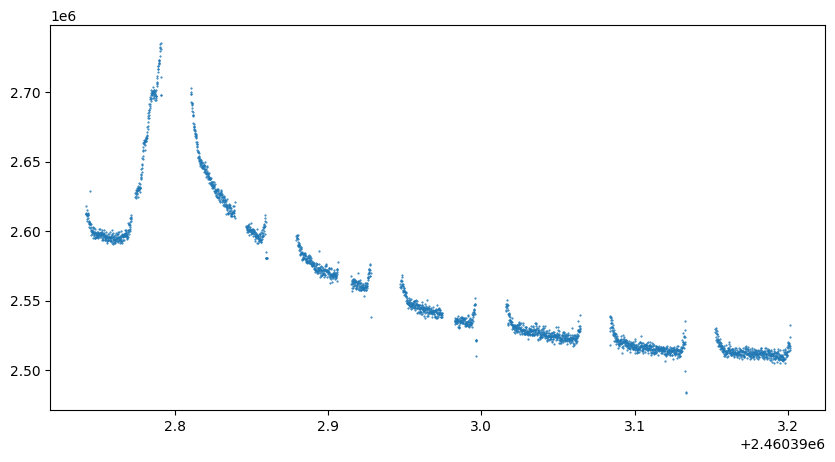

In [3]:
# remove data point above 2.9e6
egress = 2460392.71644
mask = (f < 2.9e6) & (f > 2.45e6) & (t > egress + 0.006)
t = t[mask]
f = f[mask]
roll = roll[mask]
ferr = ferr[mask]

plt.figure(figsize=(10, 5))
plt.plot(t, f, ".", markersize=1)

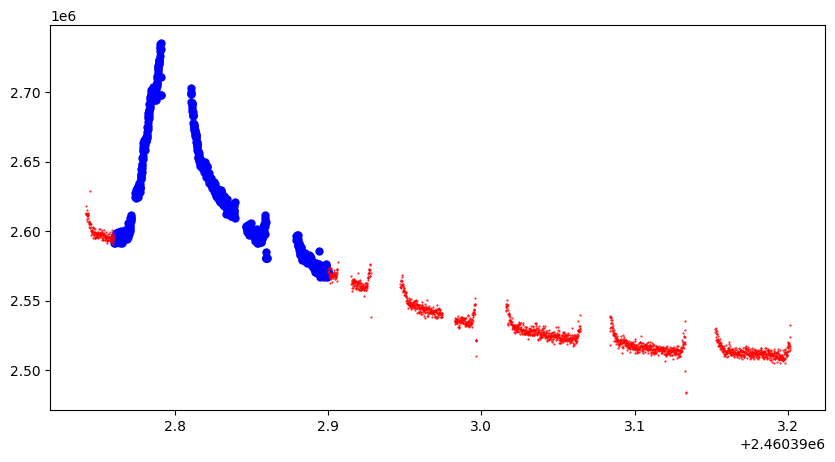

In [4]:
flare_mask = np.zeros_like(f, dtype=bool)
tmin = 2460392.76
tmax = 2460392.9
flare_mask[(t > tmin) & (t < tmax)] = True



plt.figure(figsize=(10, 5))
plt.plot(t[flare_mask], f[flare_mask], ".", markersize=10, color="blue")
plt.plot(t[~flare_mask], f[~flare_mask], ".", markersize=1, color="red")
# plt.xlim(2460392.7, 2460392.8)

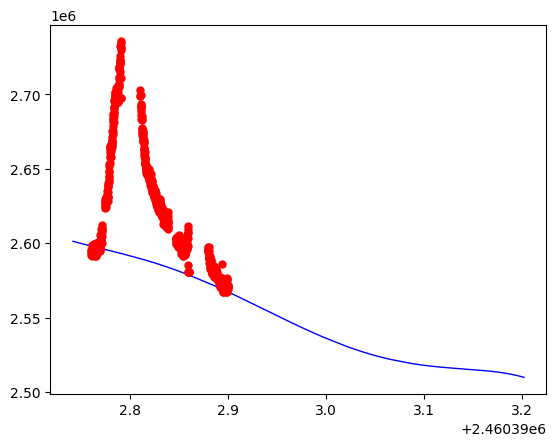

In [5]:
# fit a 3rd degree polynomial to the masked data using scipy
def func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# 3rd degree polynomial with a time offset
def func(x, a, b, c, d, e, f):
    return f * (x - 2460392.2)**5 + e * (x - 2460392.2)**4 + a * (x - 2460392.2)**3 + b * (x - 2460392.2)**2 + c * (x - 2460392.2) + d

popt, pcov = curve_fit(func, t[~flare_mask], f[~flare_mask])

fitted = func(t, *popt)




plt.plot(t, fitted, color="blue", lw=1)
# plt.plot(t, f, ".", markersize=1, color="black")
plt.plot(t[flare_mask], f[flare_mask], ".", markersize=10, color="red")

Outliers: 218


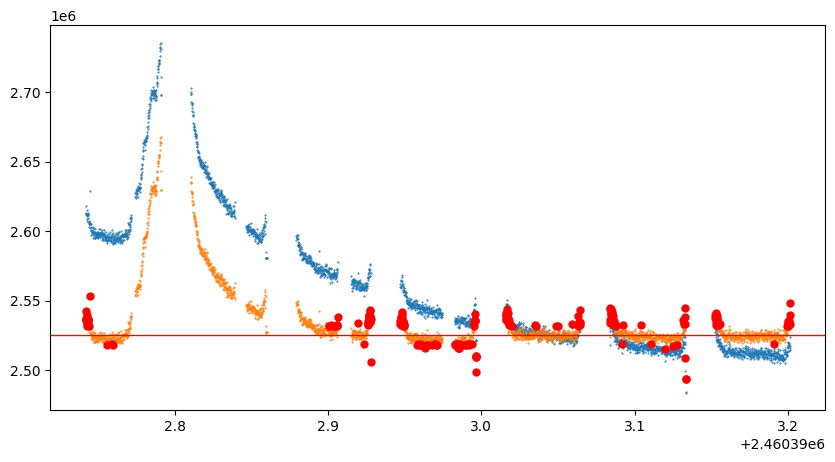

In [6]:
# subtract fitted from f
med = np.median(f[~flare_mask])
f_sub = f - fitted + med

mask_outliers = (f_sub[~flare_mask] > 1.0025 * med) | (f_sub[~flare_mask] < 0.9975 * med)
print(f"Outliers: {mask_outliers.sum()}")

plt.figure(figsize=(10, 5))
plt.plot(t, f, ".", markersize=1)
plt.plot(t, f_sub, ".", markersize=1)
plt.axhline(med, color="red", lw=1)

# plot masked outliers
plt.plot(t[~flare_mask][mask_outliers], f_sub[~flare_mask][mask_outliers], ".", markersize=10, color="red")


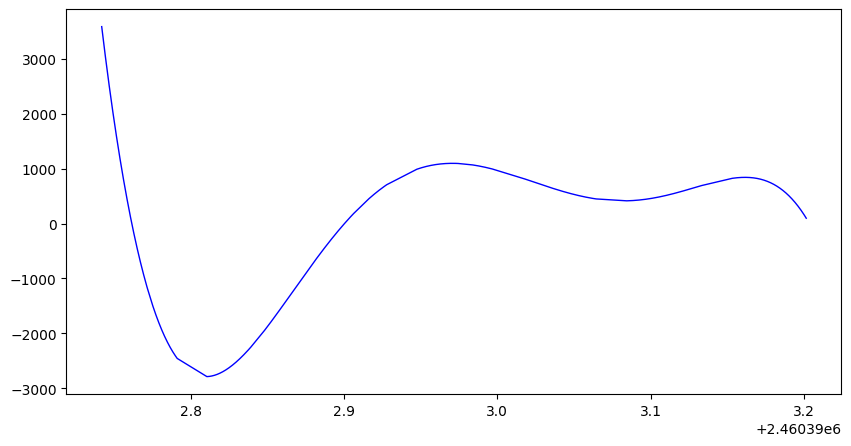

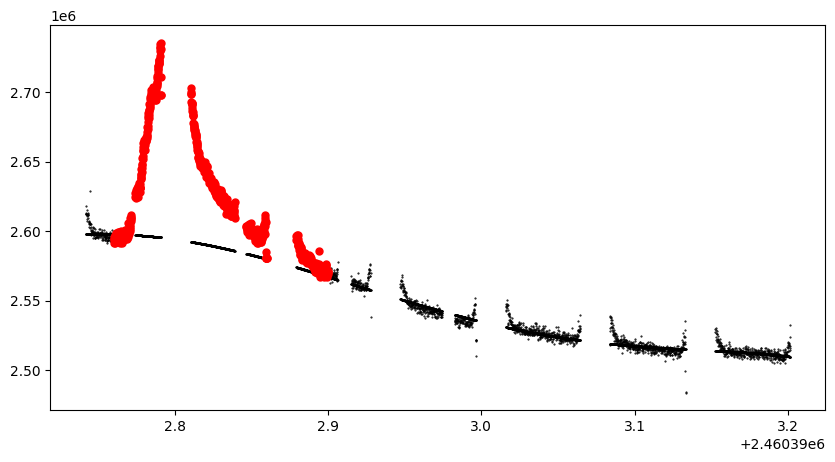

In [7]:
tnew = t[~flare_mask][~mask_outliers]
fnew = f[~flare_mask][~mask_outliers]
popt, pcov = curve_fit(func, tnew, fnew)

newfitted = func(t, *popt)
newmed = np.median(f[~flare_mask])
newf_sub = f - fitted + med


plt.figure(figsize=(10, 5))
plt.plot(t, fitted-newfitted, color="blue", lw=1)

plt.figure(figsize=(10, 5))
plt.plot(t, newfitted, ".", markersize=1, color="black")
plt.plot(t, f, ".", markersize=1, color="black")
plt.plot(t[flare_mask], f[flare_mask], ".", markersize=10, color="red")

Text(0, 0.5, 'Flux')

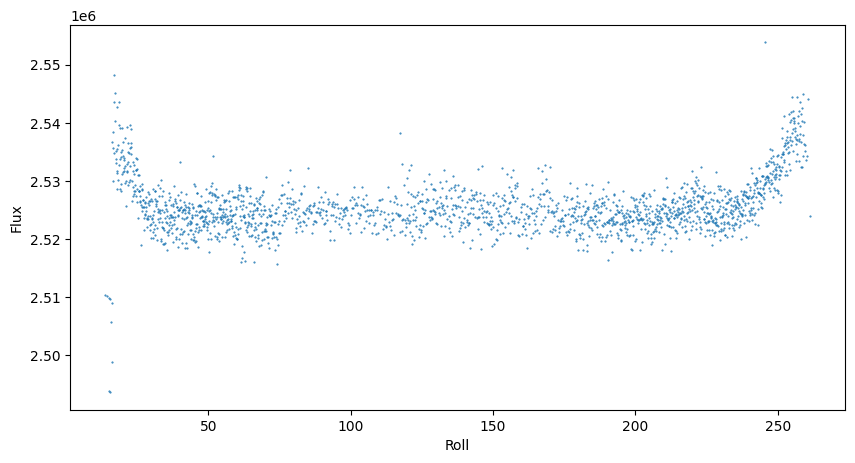

In [8]:
# plot f_sub against roll
plt.figure(figsize=(10, 5))
plt.plot(roll[~flare_mask], newf_sub[~flare_mask], ".", markersize=1)
plt.xlabel("Roll")
plt.ylabel("Flux")

Text(0, 0.5, 'Flux')

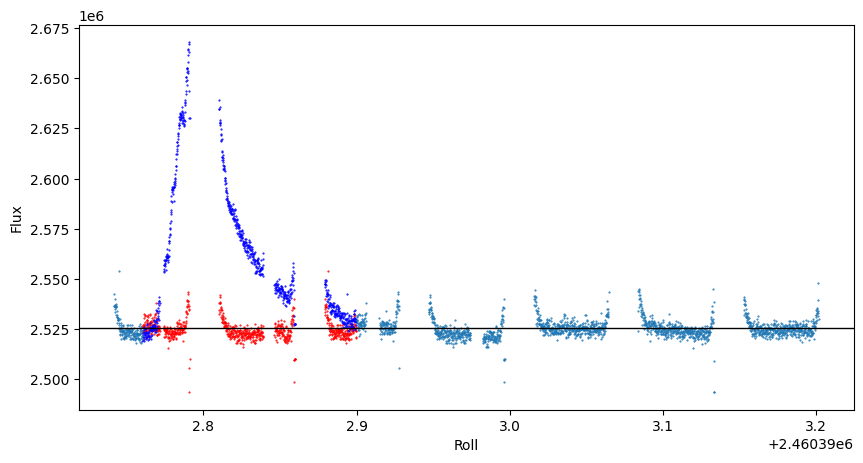

In [9]:
# approximate the flux at the roll values in the flare region with 
# the flux at the closest roll value in the non-flare region
f_sub_flare = newf_sub[flare_mask]
roll_flare = roll[flare_mask]

f_sub_no_flare = newf_sub[~flare_mask]
roll_no_flare = roll[~flare_mask]

f_sub_flare_approx = np.zeros_like(f_sub_flare)
for i, r in enumerate(roll_flare):
    idx = np.argmin(np.abs(roll_no_flare - r))
    f_sub_flare_approx[i] = f_sub_no_flare[idx]


plt.figure(figsize=(10, 5))
plt.plot(t[flare_mask], f_sub_flare_approx, ".", markersize=1, color="red")
plt.plot(t[flare_mask], f_sub_flare, ".", markersize=1, color="blue")
plt.plot(t[~flare_mask], f_sub_no_flare, ".", markersize=1)
plt.axhline(newmed, color="black", lw=1)
plt.xlabel("Roll")
plt.ylabel("Flux")


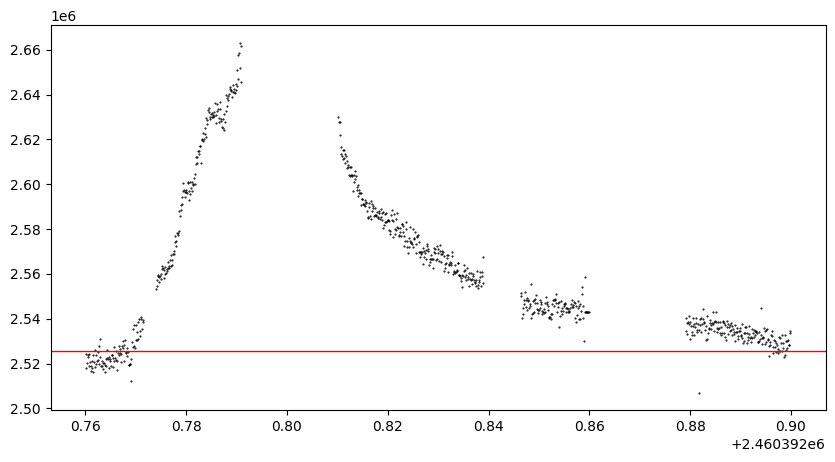

In [10]:
# subtract the interpolated flux from the flare region
f_flare = f_sub_flare - f_sub_flare_approx + newmed


plt.figure(figsize=(10, 5))
# plt.plot(t[flare_mask], f[flare_mask], ".", markersize=1)
# plt.plot(t[flare_mask], f_sub[flare_mask], ".", markersize=1)
plt.plot(t[flare_mask], f_flare, ".", markersize=1, color="black")
plt.axhline(newmed, color="red", lw=1)
# plt.xlim(2460392.75, 2460392.96)

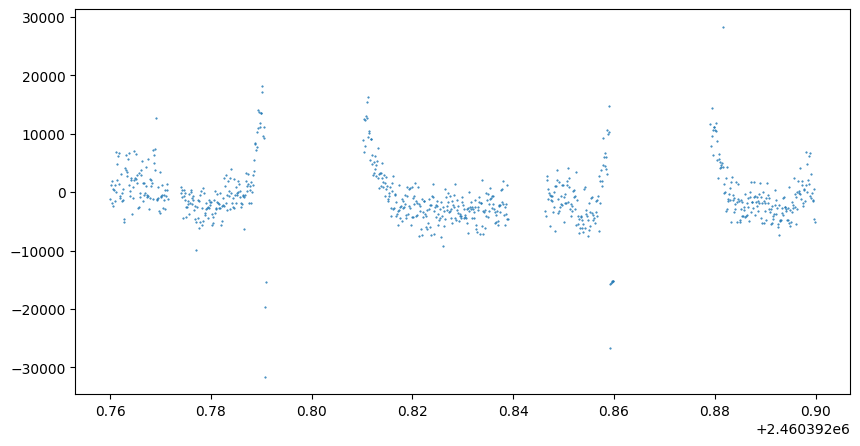

In [11]:
# plot the difference between f_sub[flare_mask] and f_flare to verify that the subtraction worked

plt.figure(figsize=(10, 5))
plt.plot(t[flare_mask], f_sub[flare_mask] - f_flare, ".", markersize=1)


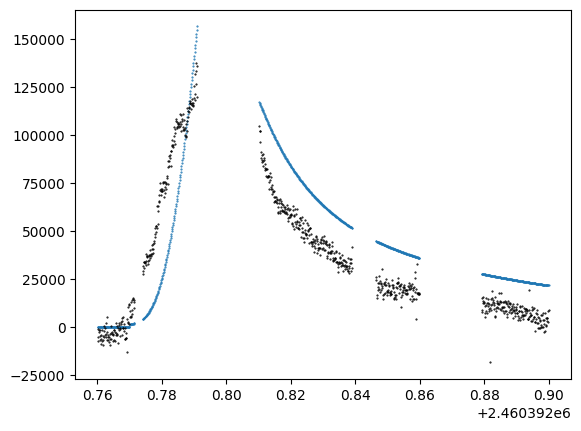

In [12]:
t_peak = 2460392.795
dur = 0.05
ampl = 0.09*newmed
parametrization = "davenport2014"
f = flare_model(parametrization, t[flare_mask], t_peak, dur, ampl)
plt.plot(t[flare_mask], f, ".", markersize=1)
plt.plot(t[flare_mask], f_flare-newmed, ".", markersize=1, color="black")

[2.46039279e+06 5.00000000e-02 2.27294540e+05]


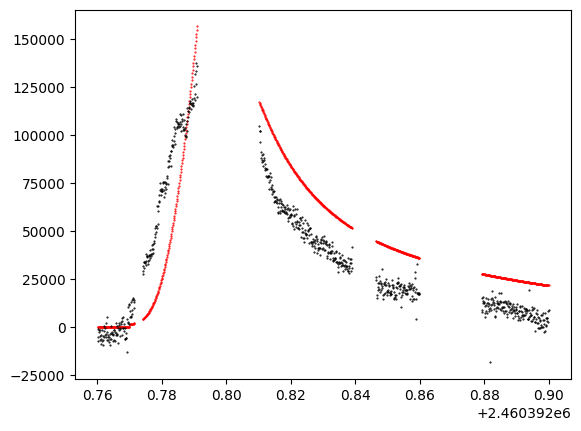

In [13]:
# fit the flare model to f_flare
def flare_fit_model(t, t_peak, dur, ampl):
    return flare_model(parametrization, t, t_peak, dur, ampl)

popt, pcov = curve_fit(flare_fit_model, t[flare_mask], f_flare-newmed, p0=[t_peak, dur, ampl])

plt.plot(t[flare_mask], flare_fit_model(t[flare_mask], *popt), ".", markersize=1, color="red")
plt.plot(t[flare_mask], f_flare-med, ".", markersize=1, color="black")

print(popt)

In [14]:
# write an mcmc procedure to fit the flare model to the data
# use the emcee package

import emcee

ferrstd = np.std(newf_sub[~flare_mask])

def log_likelihood(theta, t, f, ferrstd):
    t_peak, dur, ampl = theta
    model = flare_fit_model(t, t_peak, dur, ampl)
    return -0.5 * np.sum((f - model)**2 / ferrstd**2)

def log_prior(theta):
    t_peak, dur, ampl = theta
    if 2460392.77 < t_peak < 2460392.83 and 0.0 < dur < 0.1 and 0.01 < ampl < 1e7:
        return 0.0
    return -np.inf

def log_probability(theta, t, f, ferrstd):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, f, ferrstd)

ndim = 3
nwalkers = 32
nsteps = 2000

pos = popt + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t[flare_mask], f_flare-newmed, ferrstd))

sampler.run_mcmc(pos, nsteps, progress=True);


100%|██████████| 2000/2000 [00:04<00:00, 471.35it/s]


Text(0.5, 0, 'step number')

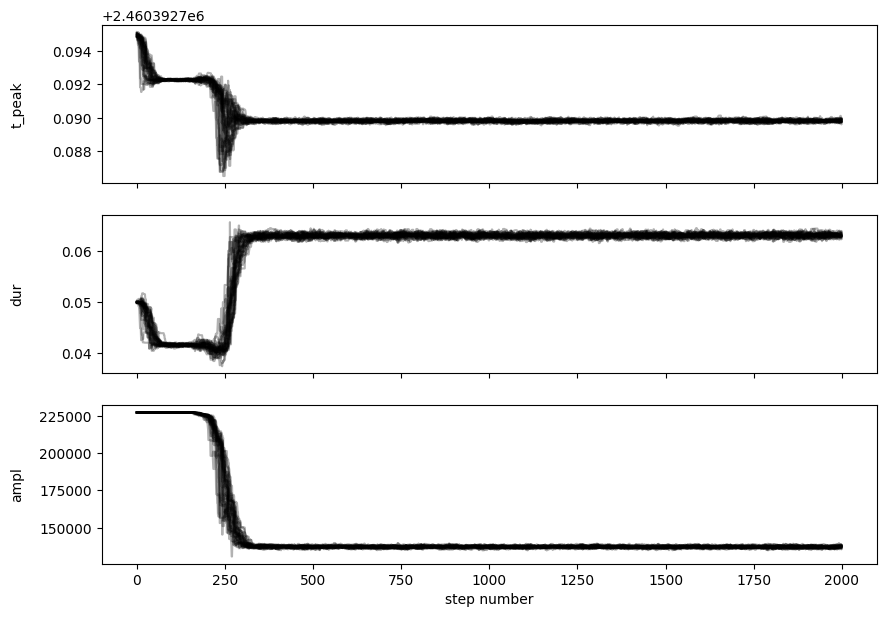

In [15]:
# plot the chains
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t_peak", "dur", "ampl"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
    

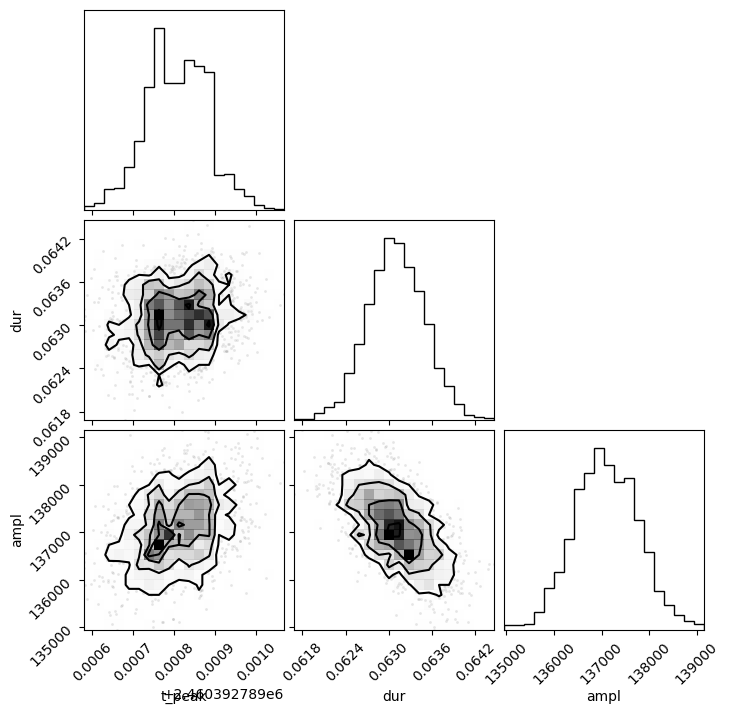

In [16]:
# plot the corner plot
import corner

flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=popt
)



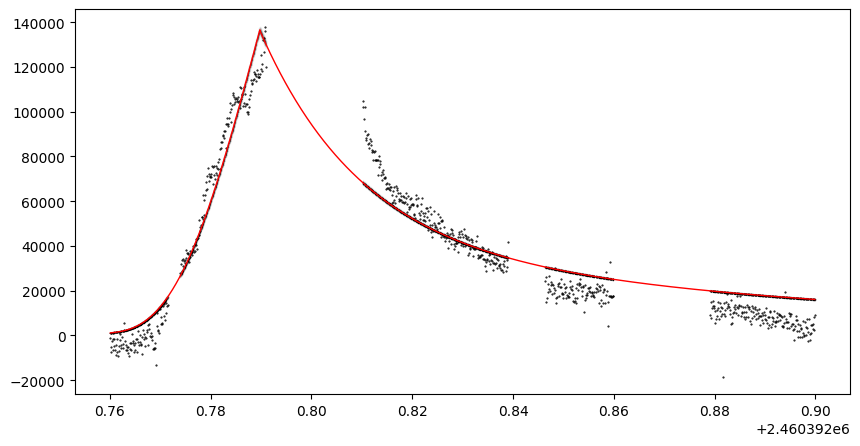

In [17]:
# plot the best fit model
t_peak, dur, ampl = np.median(flat_samples, axis=0)
plt.figure(figsize=(10, 5))

# sample 100 random samples from the chain

for i in np.random.randint(len(flat_samples), size=100):
    sample = flat_samples[i]
    plt.plot(t[flare_mask], flare_fit_model(t[flare_mask], *sample),  ".", color="black", alpha=0.01, markersize=1)


plt.plot(t[flare_mask], f_flare-newmed, ".", markersize=1, color="black")

# interpolate the flare model in the gaps
t_peak, dur, ampl = np.median(flat_samples, axis=0)
t_interpolate = np.linspace(t[flare_mask].min(), t[flare_mask].max(), 1000)
f_interpolate = flare_fit_model(t_interpolate, t_peak, dur, ampl)
plt.plot(t_interpolate, f_interpolate, color="red", lw=1)


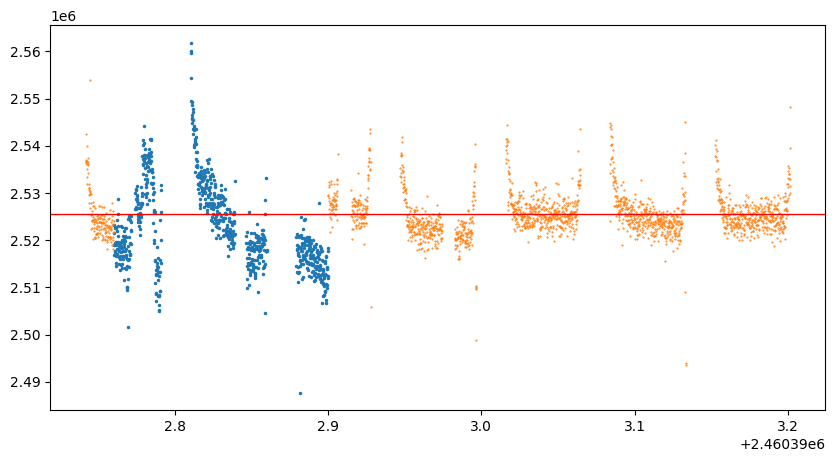

In [18]:
# subtract model from f_flare
residuals = f_flare - flare_fit_model(t[flare_mask], t_peak, dur, ampl) 

plt.figure(figsize=(10, 5))
plt.plot(t[flare_mask], residuals, ".", markersize=3)
plt.plot(t[~flare_mask], newf_sub[~flare_mask], ".", markersize=1)
plt.axhline(newmed, color="red", lw=1)

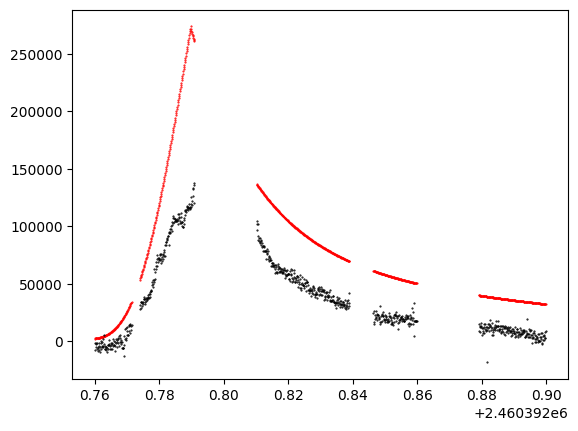

In [20]:
# now fit a two component model to the flare light curve
def flare_fit_model(t, t_peak, dur, ampl, t_peak2, dur2, ampl2):
    return flare_model(parametrization, t, t_peak, dur, ampl) + flare_model(parametrization, t, t_peak2, dur2, ampl2)


tpeak2 = 2460392.81
dur2 = 0.02
ampl2 = 0.04*newmed
popt, pcov = curve_fit(flare_fit_model, t[flare_mask], f_flare-newmed, p0=[t_peak, dur, ampl, t_peak, dur, ampl])

plt.plot(t[flare_mask], flare_fit_model(t[flare_mask], *popt), ".", markersize=1, color="red")
plt.plot(t[flare_mask], f_flare-med, ".", markersize=1, color="black")


In [21]:
# write an mcmc procedure to fit the flare model to the data
# use the emcee package


ferrstd = np.std(newf_sub[~flare_mask])

def log_likelihood(theta, t, f, ferrstd):
    t_peak, dur, ampl, t_peak2, dur2, ampl2 = theta
    model = flare_fit_model(t, t_peak, dur, ampl, t_peak2, dur2, ampl2)
    return -0.5 * np.sum((f - model)**2 / ferrstd**2)

def log_prior(theta):
    t_peak, dur, ampl, t_peak2, dur2, ampl2 = theta
    if  ((2460392.77 < t_peak < 2460392.83) and 
        (0.0 < dur < 0.1) and 
        (0.01 < ampl < 1e7) and 
        (2460392.77 < t_peak2 < 2460392.83) and 
        (0.0 < dur2 < 0.1) and 
        (0.01 < ampl2 < 1e7)):
        return 0.0
    return -np.inf

def log_probability(theta, t, f, ferrstd):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, f, ferrstd)

ndim = 6
nwalkers = 32
nsteps = 2000

pos = popt + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t[flare_mask], f_flare-newmed, ferrstd))

sampler.run_mcmc(pos, nsteps, progress=True);

100%|██████████| 2000/2000 [00:06<00:00, 329.88it/s]


Text(0.5, 0, 'step number')

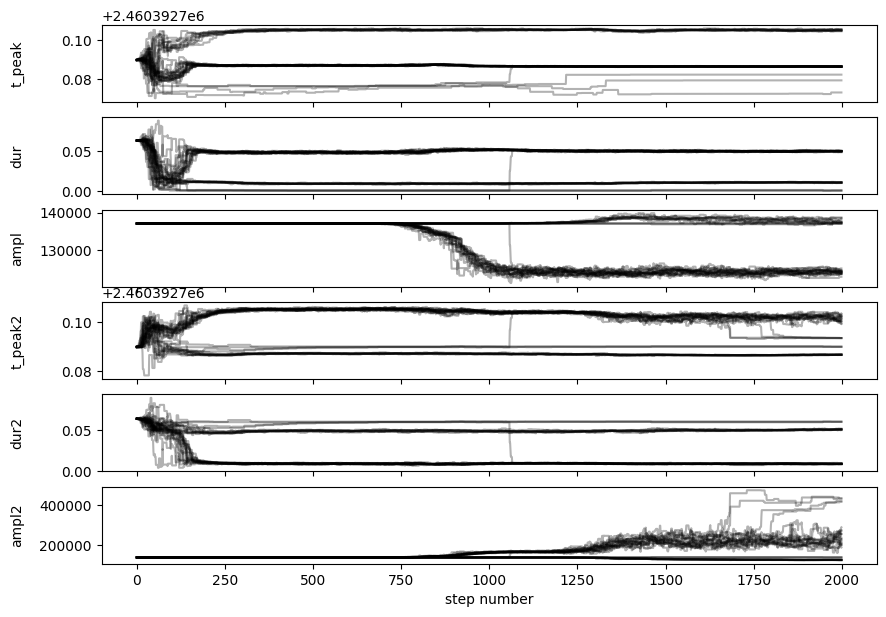

In [22]:
# plot the chains
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t_peak", "dur", "ampl", "t_peak2", "dur2", "ampl2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


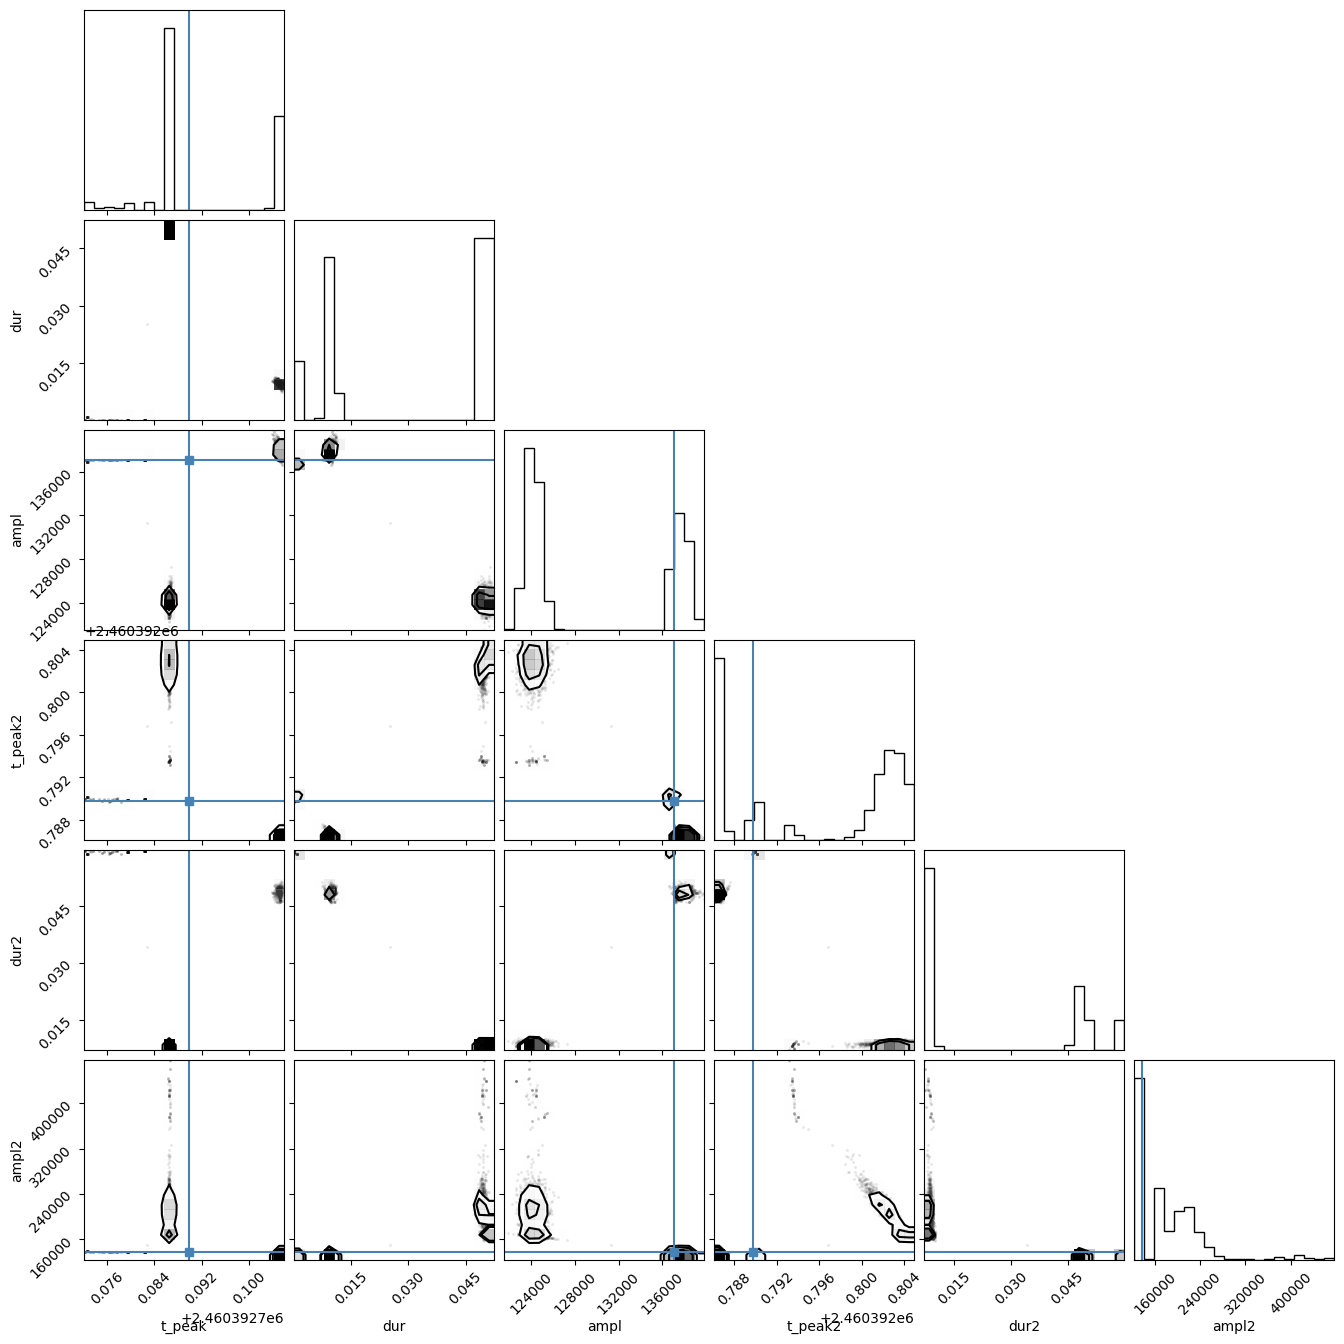

In [23]:
# plot the corner plot
import corner

flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=popt
)


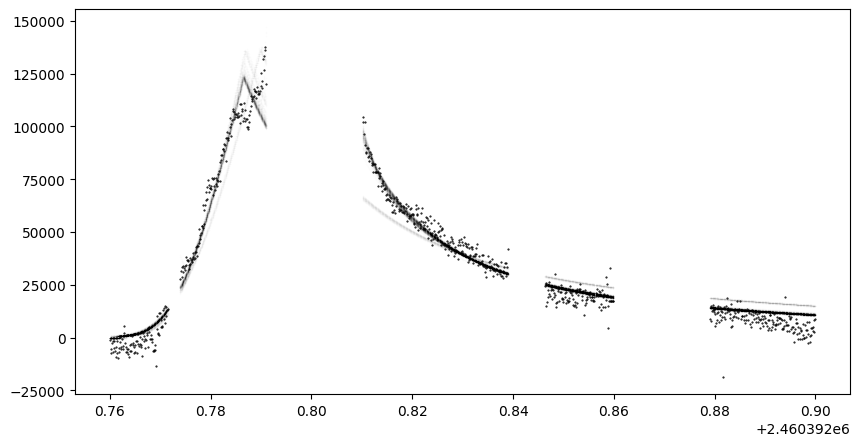

In [24]:
# plot the best fit model
t_peak, dur, ampl, t_peak2, dur2, ampl2 = np.median(flat_samples, axis=0)
plt.figure(figsize=(10, 5))

# sample 100 random samples from the chain

for i in np.random.randint(len(flat_samples), size=100):
    sample = flat_samples[i]
    plt.plot(t[flare_mask], flare_fit_model(t[flare_mask], *sample),  ".", color="black", alpha=0.01, markersize=1)


plt.plot(t[flare_mask], f_flare-newmed, ".", markersize=1, color="black")
